In [ ]:
import numpy as np
import pandas as pd

import argparse
import os

from psd_utils import lnprob, grab_data, model

from scipy.optimize import minimize, OptimizeResult

import matplotlib.pyplot as plt
from IPython.display import clear_output

class FitDebug:
    def __init__(self, freq, powers):
        self.freq = freq
        self.powers = powers

        self.losses = []
        self.n_iter = 0
    
    def update(self, int_res: OptimizeResult):
        self.losses.append(-lnprob(int_res, self.freq, self.powers))
        self.n_iter += 1

        if self.n_iter % 1 != 0: return

        clear_output(wait=True)

        fig, (model_ax, loss_ax) = plt.subplots(1, 2, figsize=(10,5))

        model_ax.plot(self.freq, self.powers, color="gray")
        step_vec = int_res.copy()
        step_vec[[1, 2, 3, 5]] = 10**(step_vec[[1, 2, 3, 5]])
        model_ax.plot(self.freq, model(self.freq, step_vec))
        model_ax.set_xscale("log")
        model_ax.set_yscale("log")

        loss_ax.plot(np.arange(self.n_iter), self.losses)
        loss_ax.relim()
        # print(dir(int_res))
        # loss_ax.text(
        #     x=0.1,
        #     y=0.1,
        #     s="\n".join(f"{label}: {value:.5g}" for label, value in zip(["nu_max", "H", "P", "tau", "alpha"], step_vec))
        # )

        plt.show()
    
    def __call__(self, *args, **kwargs):
        return self.update(*args, **kwargs)

def fit_star(kic_id: str, star_row: pd.Series):
    freq, powers = grab_data(kic_id)

    W0 = np.median(powers[-40:])

    x0 = np.array(list(star_row[["nu_max", "H", "P", "tau", "alpha"]]) + [W0])
    
    x0_logged = x0.copy()
    x0_logged[[1, 2, 3, 5]] = np.log10(x0[[1, 2, 3, 5]])

    debug_listener = FitDebug(freq, powers)
    
    min_res: OptimizeResult = minimize(lambda t: -lnprob(t, freq, powers)/len(freq), x0_logged, method="Nelder-Mead", callback=debug_listener)

    print(min_res)

def fit_stars(data_table: pd.DataFrame):
    for (kic_id, row) in data_table.iterrows():
        print("fitting ", kic_id)
        fit_star(kic_id, row) # type: ignore

def parse_args() -> pd.DataFrame:
    argparser = argparse.ArgumentParser()
    
    env_default = os.environ.get("RED_GIANT_DATA_PATH")
    argparser.add_argument(
        "--data-path",
        type=str,
        default=env_default,
        help="Path to data (defaults to $RED_GIANT_DATA_PATH)"
    )

    argparser.add_argument(
        "--start-id",
        type=int,
        default=0,
        help="First row to process."
    )

    argparser.add_argument(
        "--end-id",
        type=int,
        default=None,
        help="Last row (exclusive) to process"
    )

    args = argparser.parse_args()

    if args.data_path is None:
        argparser.error("Need either the --data-path flag or "
                        "$RED_GIANT_DATA_PATH environmental variable to be set")
    
    try:
        full_df = pd.read_csv(args.data_path, index_col="KIC")
    except Exception as e:
        argparser.error(f"Could not read {args.data_path}!\n{e}")

    column_difference = {"nu_max", "H", "P", "tau", "alpha"}.difference(full_df.columns)
    if column_difference:
        argparser.error(f"{args.data_path} does not have required columns {column_difference}")

    if args.start_id < 0:
        argparser.error(f"--start-id must be within bounds of data ([0, {len(full_df)}))")

    if args.end_id is None:
        args.end_id = len(full_df)

    if args.end_id > len(full_df) or args.end_id < args.start_id:
        argparser.error(f"--end-id must be within bounds of data ([0, {len(full_df)}])")

    return full_df.iloc[args.start_id:args.end_id]

In [ ]:
data = pd.read_csv(os.environ.get("RED_GIANT_DATA_PATH", ""), index_col="KIC")

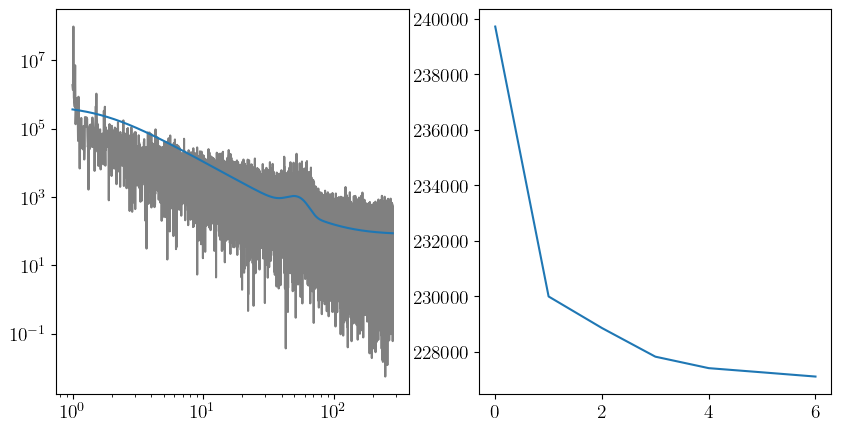

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 6.38162372194451
        x: [ 5.155e+01  2.817e+00  5.684e+00  4.975e+00  2.128e+00
             1.917e+00]
      nit: 7
      jac: [-1.280e-03 -1.112e-02  4.786e-02 -1.150e-01 -3.399e-02
             5.018e-02]
 hess_inv: [[ 1.012e+00 -1.070e-01 ... -1.668e-01 -2.871e-02]
            [-1.070e-01  2.210e+00 ...  1.484e+00  2.019e-01]
            ...
            [-1.668e-01  1.484e+00 ...  3.130e+00  4.428e-01]
            [-2.871e-02  2.019e-01 ...  4.428e-01  4.320e-01]]
     nfev: 93
     njev: 12


/home/andres/miniforge3/envs/astro/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [7]:
fit_stars(data.iloc[44:45])

In [11]:
bad_fits = pd.read_csv("refit_output/merged_refit.csv", index_col="KIC")
bad_fits = bad_fits[~bad_fits['success']]
bad_fits

,nu_max,H,P,tau,alpha,W,success,status
KIC,,,,,,,,
1572049,51.553814,630.469703,4.992143e+05,98266.779751,2.114232,84.139908,False,2
2845610,91.645812,153.289139,4.162399e+03,10136.124168,2.329030,14.987094,False,2
2860936,101.710354,1077.965285,5.507617e+04,32027.405602,1.442789,0.122507,False,2
3122185,99.919453,273.214055,3.714860e+04,99519.818390,1.373849,19.221109,False,2
4065054,86.286666,337.275633,9.735921e+05,24083.584421,1.545044,0.100423,False,2
...,...,...,...,...,...,...,...,...
11775041,34.074619,150.083305,1.550712e+04,6761.900031,3.944980,56.653204,False,2
11805390,31.530372,18903.772132,1.812665e+06,22772.096069,2.474443,489.428079,False,2
12266731,94.798746,151.551225,2.465560e+04,31540.795112,1.967272,137.871918,False,2


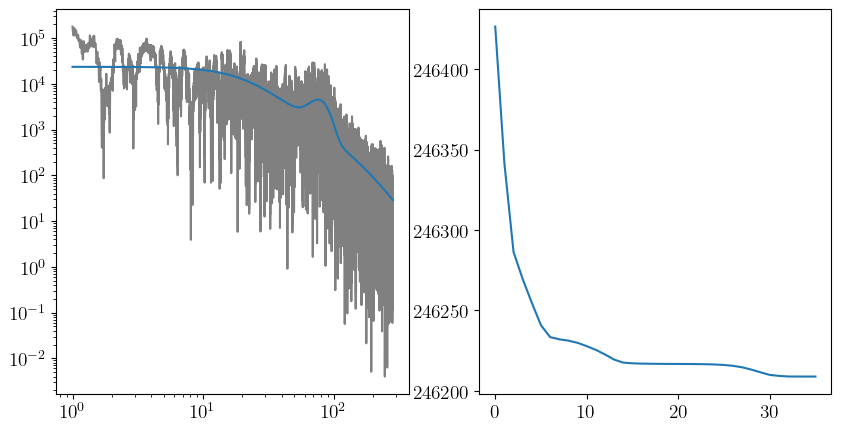

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 7.103546033951239
        x: [ 7.754e+01  3.565e+00  4.375e+00  3.873e+00  2.316e+00
             6.900e-01]
      nit: 36
      jac: [ 1.192e-07 -7.749e-07  6.557e-07 -3.099e-06 -2.086e-06
             1.788e-07]
 hess_inv: [[ 1.814e+03 -3.268e+01 ...  3.366e+01  9.658e+01]
            [-3.268e+01  2.778e+00 ... -1.810e+00 -1.135e+00]
            ...
            [ 3.366e+01 -1.810e+00 ...  1.240e+01  3.740e+01]
            [ 9.658e+01 -1.135e+00 ...  3.740e+01  2.291e+02]]
     nfev: 266
     njev: 38


In [12]:
fit_stars(bad_fits)

In [ ]:
#pickup note: run this cell :)

/tmp/ipykernel_32328/1104049249.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, model_ax = plt.subplots()


KeyboardInterrupt: 

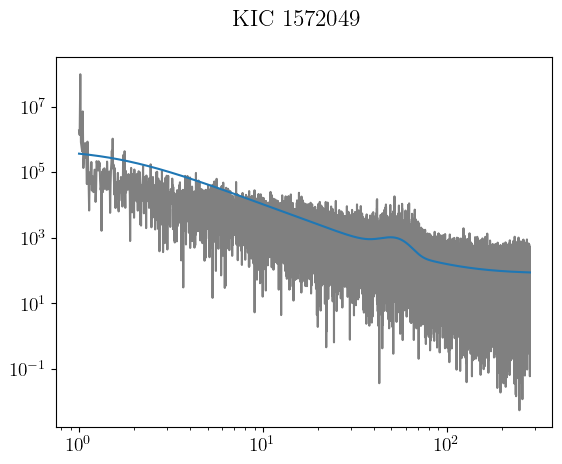

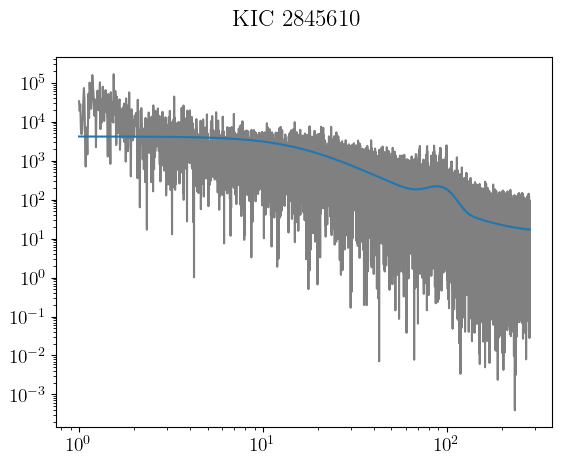

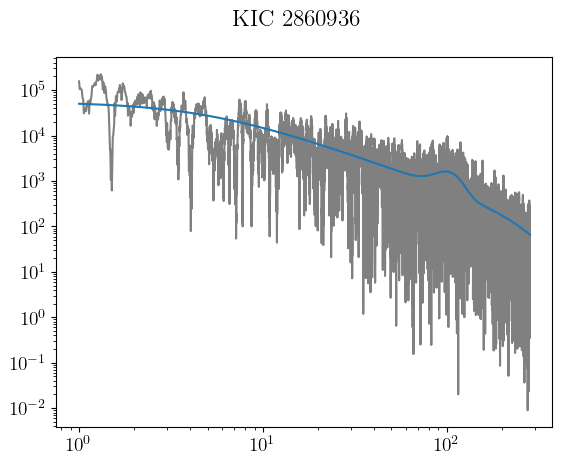

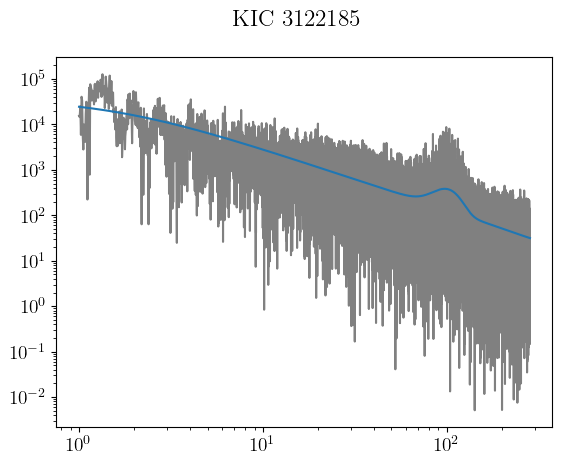

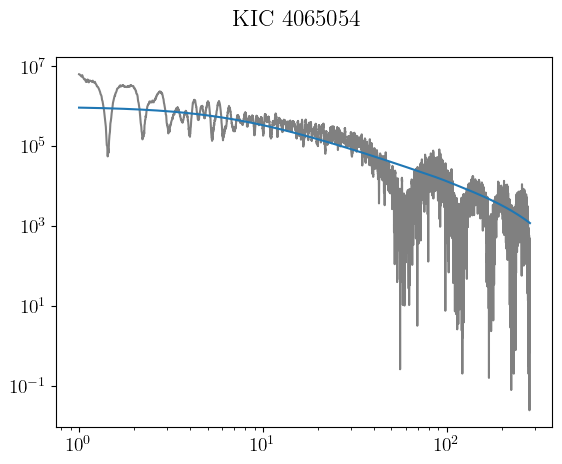

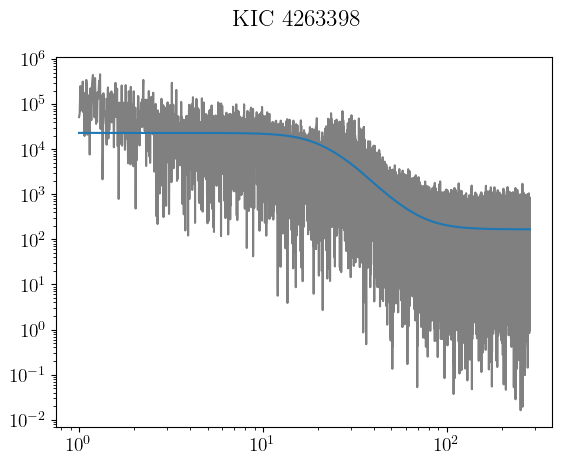

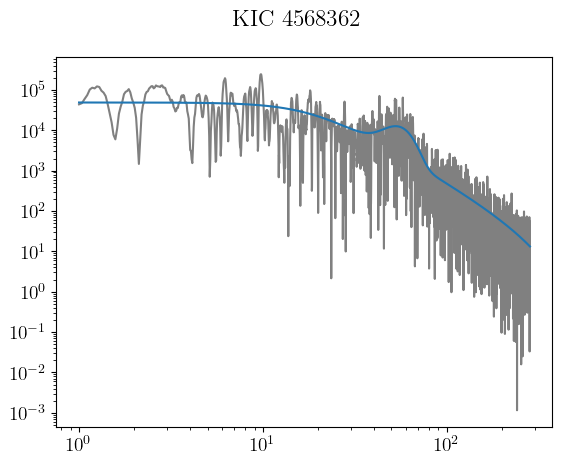

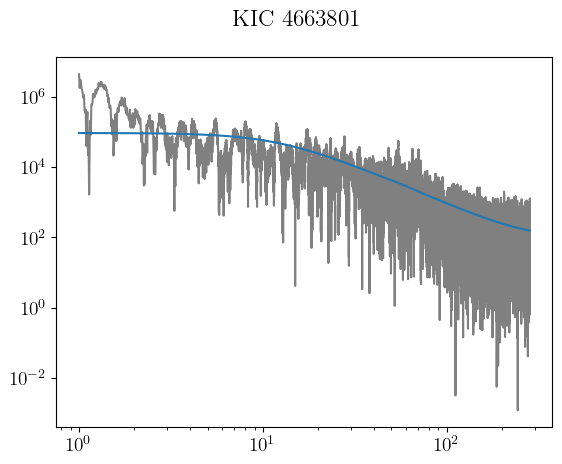

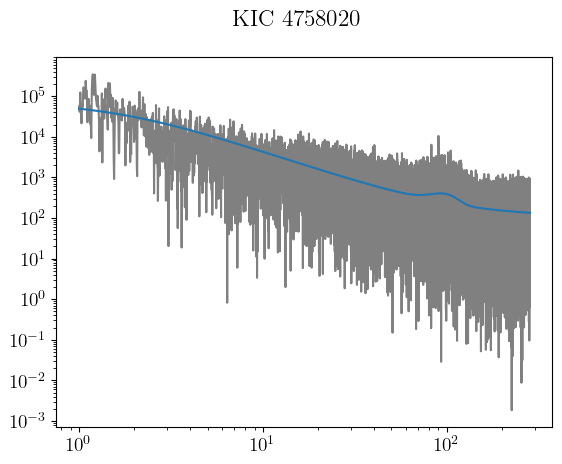

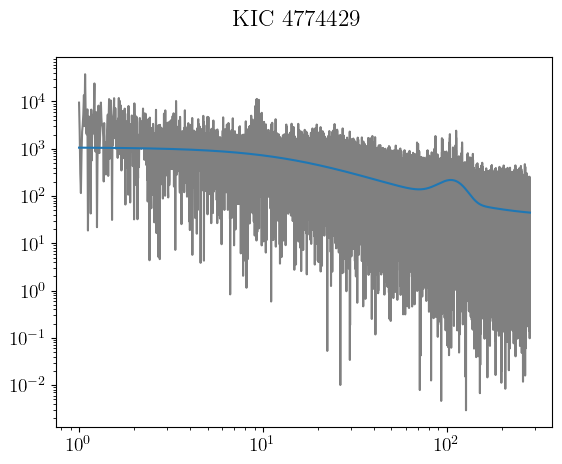

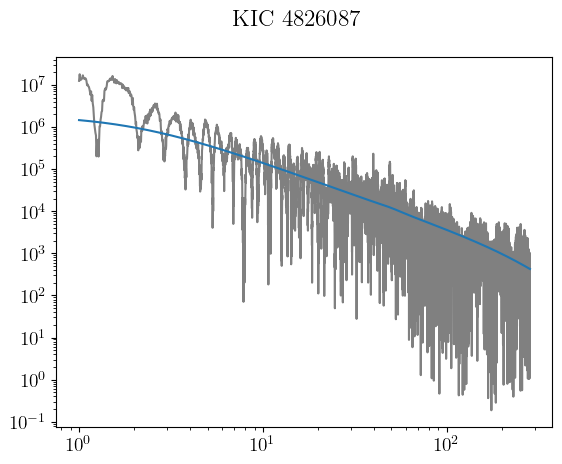

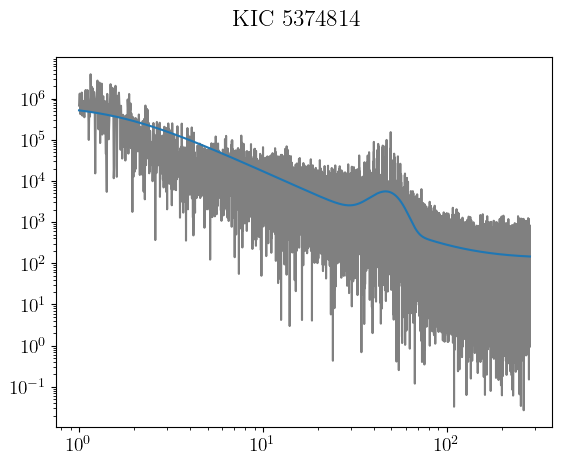

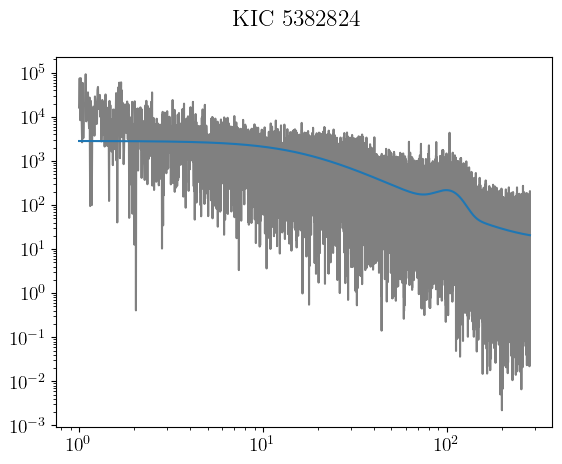

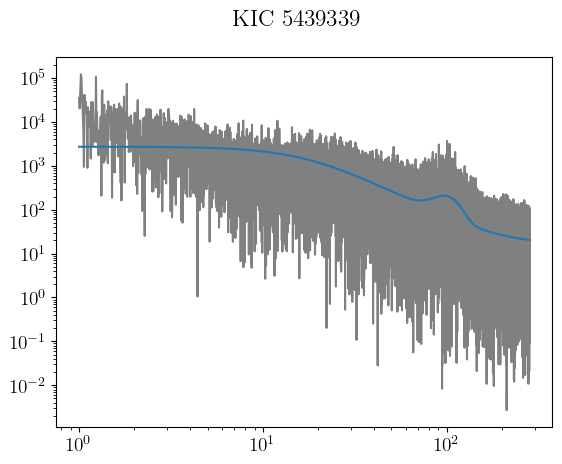

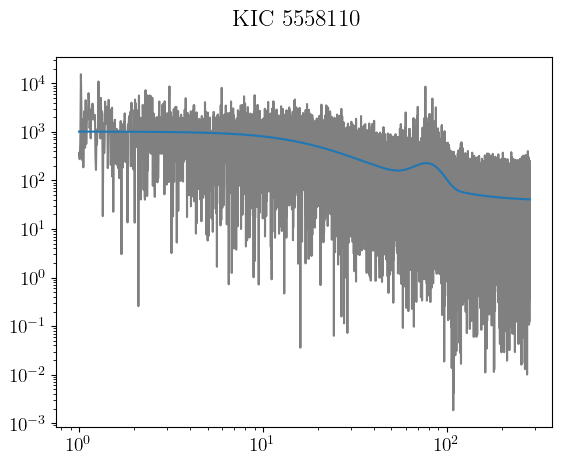

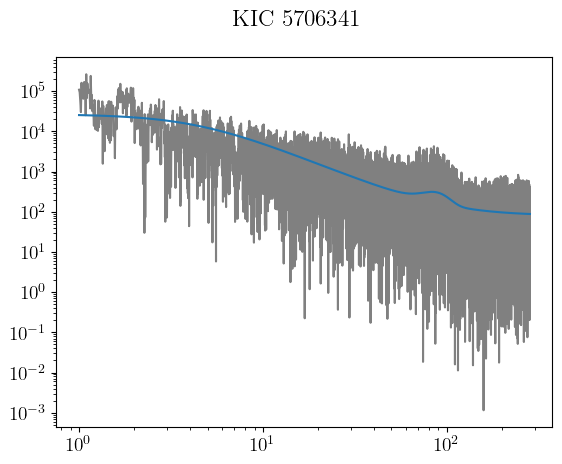

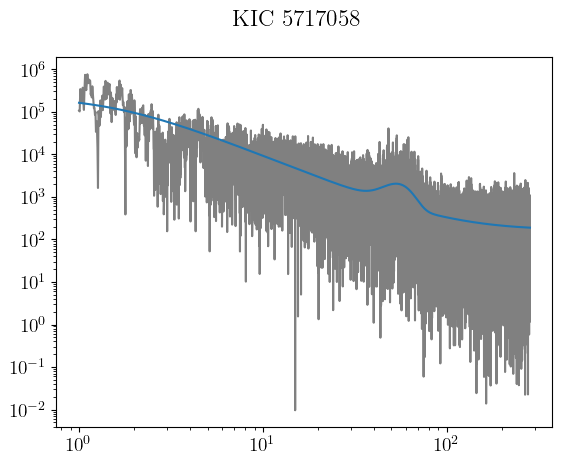

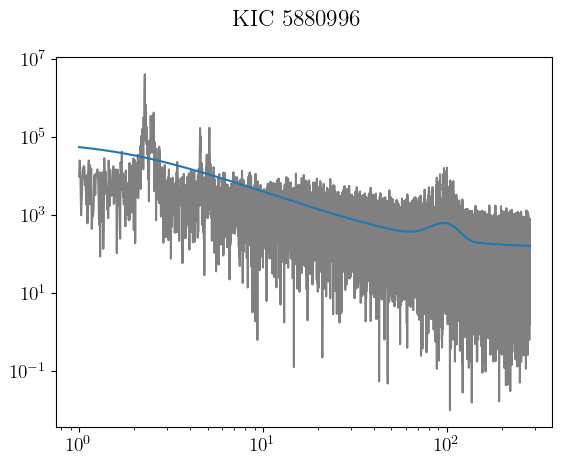

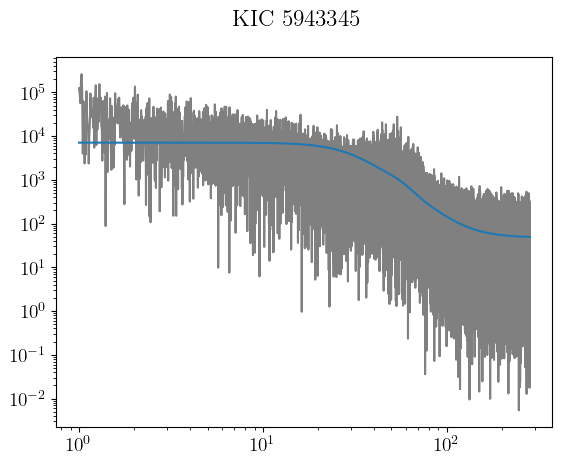

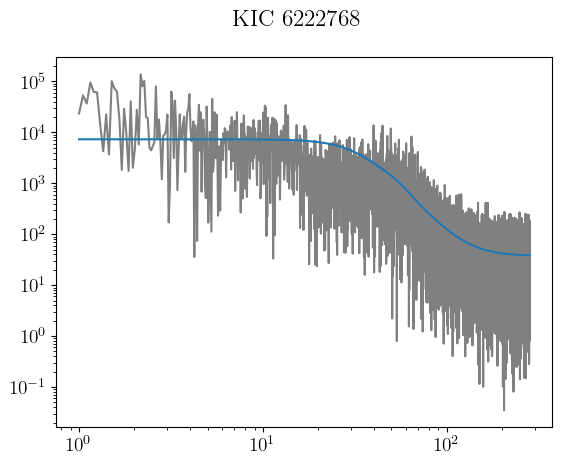

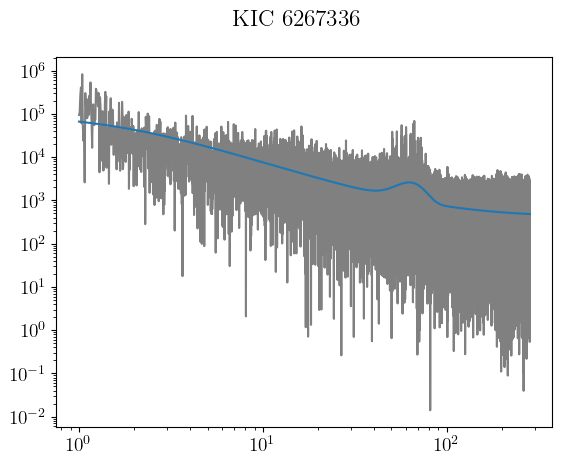

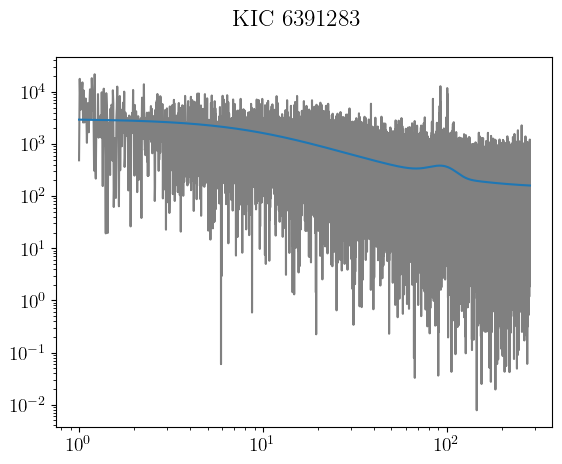

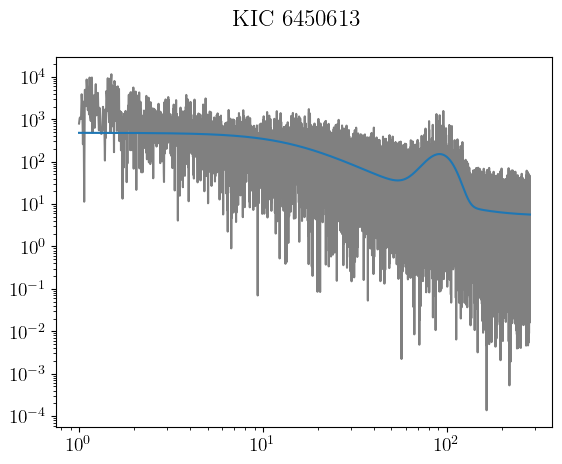

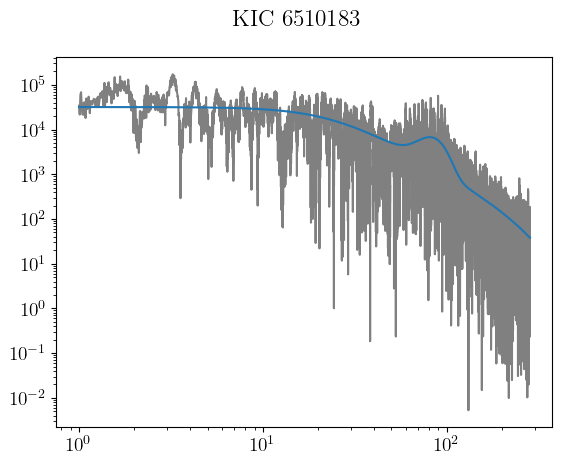

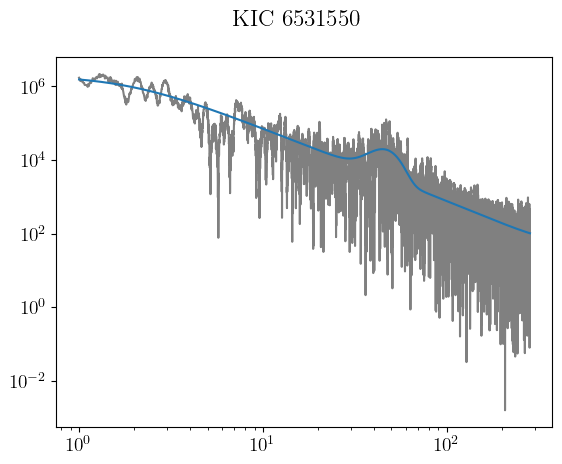

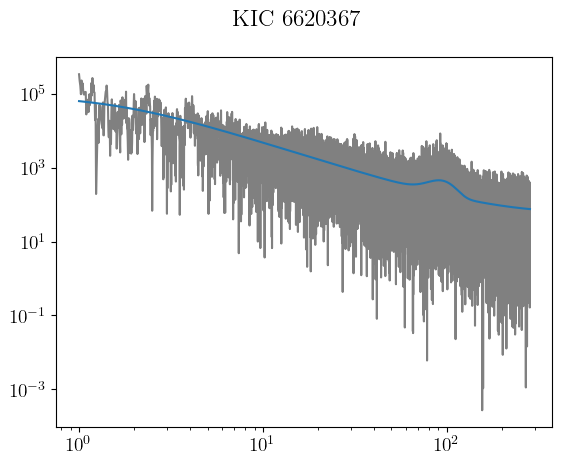

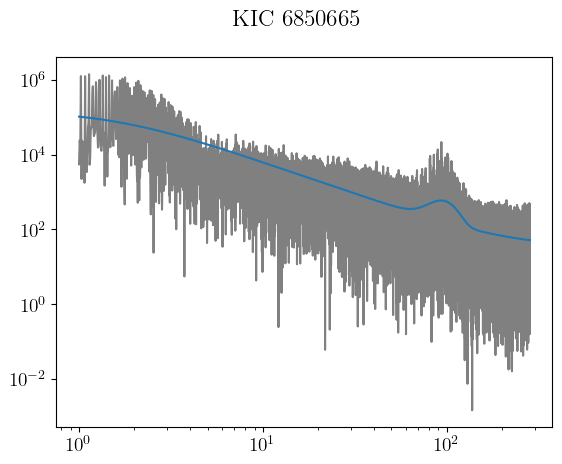

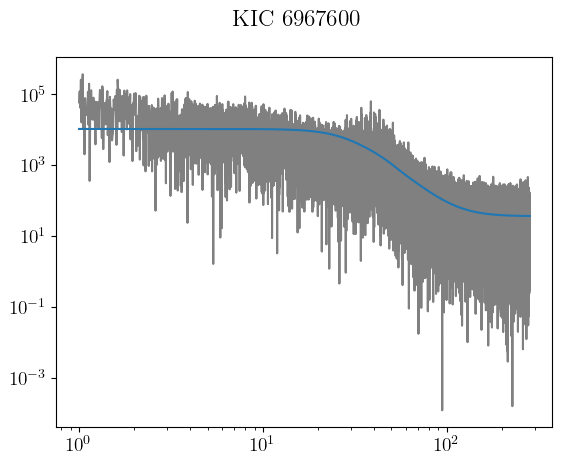

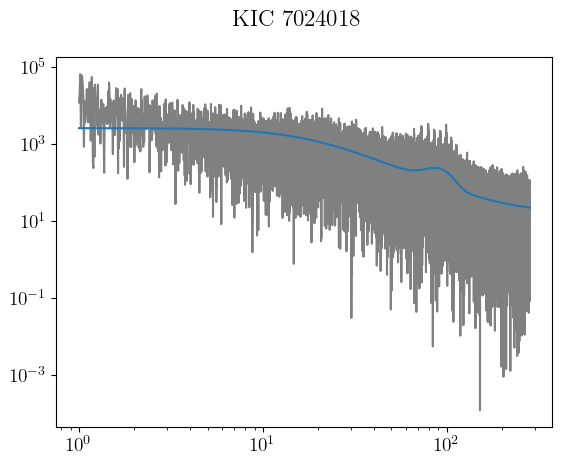

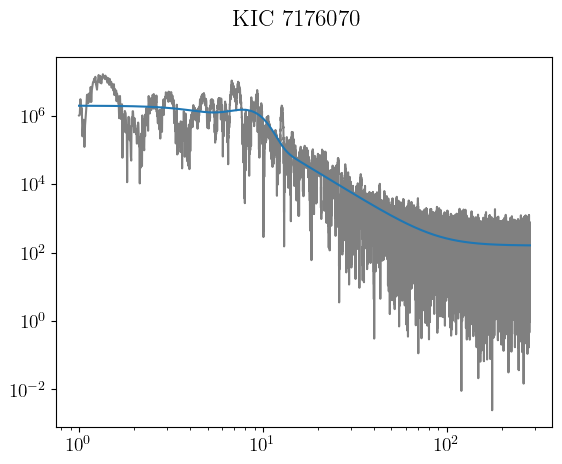

In [22]:
for name, row in bad_fits.iterrows():
    params = row[["nu_max", "H", "P", "tau", "alpha", "W"]]
    freq, powers = grab_data(name)
    fig, model_ax = plt.subplots()

    model_ax.plot(freq, powers, color="gray")
    step_vec = params.values.copy()
    # step_vec[[1, 2, 3, 5]] = 10**(step_vec[[1, 2, 3, 5]])
    model_ax.plot(freq, model(freq, step_vec))
    model_ax.set_xscale("log")
    model_ax.set_yscale("log")

    fig.suptitle(f"KIC {name}")
    fig.savefig(f"bad_fits/bad_fit_{name}.png")
    plt.close(fig)